#### Hidden Manifolds in High Dimensional Space


Run dimensionality reduction on spike counts.


In [2]:
from __future__ import division
import numpy as np
import numpy.linalg as la
import sys, time, os, datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition, manifold

In [2]:
import matplotlib.pyplot as plt

In [4]:
sd=int((time.time()%1)*(2**31))
np.random.seed(sd)
curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'

gen_fn_dir = os.path.abspath('..') + '/shared_scripts'
sys.path.append(gen_fn_dir)

import general_file_fns as gff

gen_params = gff.load_pickle_file('../general_params/general_params.p')

from binned_spikes_class import spike_counts
from dim_red_fns import run_dim_red

In [4]:
cols = gen_params['cols']
dir_to_save = gff.return_dir(gen_params['results_dir'] + '2019_06_03_dim_red/')

command_line = False
if command_line:
    session = sys.argv[1]
    state = sys.argv[2]
    # If condition is 'joint' should unpack state into first and second
    condition = sys.argv[3]
    target_dim = int(sys.argv[4])
    desired_nSamples = int(sys.argv[5])
else:
    session = 'Mouse28-140313'
    state = 'Wake'; #state2 = 'REM'
    condition = 'solo'
    target_dim = 3
    desired_nSamples = 15000

print('Session %s, condition %s, target_dim %d, desired_nSamples %d'%(session, condition,
    target_dim, desired_nSamples))
area = 'ADn'
dt_kernel = 0.1
sigma = 0.1 # Kernel width
rate_params = {'dt' : dt_kernel, 'sigma' : sigma}
method = 'iso'
n_neighbors = 5
dim_red_params = {'n_neighbors' : n_neighbors, 'target_dim' : target_dim}
to_plot = True

session_rates = spike_counts(session, rate_params, count_type='rate', 
    anat_region='ADn')

Session Mouse28-140313, condition solo, target_dim 3, desired_nSamples 15000


In [5]:
counts, tmp_angles = session_rates.get_spike_matrix(state)

In [6]:
#22 cells
len(session_rates.cell_ids)

22

In [7]:
counts.shape

(22864, 22)

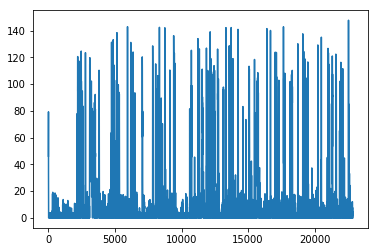

In [8]:
plt.plot(counts[:,3])
plt.show()

In [17]:
t0 = time.time()
if condition == 'solo':
    counts, tmp_angles = session_rates.get_spike_matrix(state)
    
    ##Yonar's edit
    #idx = np.random.rand(*counts.shape).argsort(0)
    #counts_shuffled = counts[idx, np.arange(counts.shape[1])]
    #sel_counts = counts_shuffled[:desired_nSamples]
    #np.random.shuffle(counts)
    
    sel_counts = counts[:desired_nSamples,:6]
    
    proj = run_dim_red(sel_counts, params=dim_red_params, method=method)
    to_save = {'seed' : sd, state : proj, 'meas_angles' : tmp_angles[:desired_nSamples]}
    fname = '%s_%s_kern_%dms_sigma_%dms_binsep_%s_embed_%s_%ddims_%dneighbors_%d.p'%(
        session, area, sigma * 1000, dt_kernel * 1000, state, method, target_dim, n_neighbors, 
       sd)
elif condition == 'joint':
    counts1, _ = session_rates.get_spike_matrix(state)
    counts2, _ = session_rates.get_spike_matrix(state2)
    print('Counts for each ', len(counts1), len(counts2))
    nSamples = min(len(counts1), len(counts2), desired_nSamples)
    print('nSamples = ', nSamples)
    sel1 = counts1[:nSamples]; sel2 = counts2[:nSamples]
    concat_counts = np.concatenate((sel1,sel2),0)
    proj = run_dim_red(concat_counts, params=dim_red_params, method=method)
    to_save = {'seed':sd, state : proj[:nSamples].copy(), 
        state2 : proj[nSamples:].copy()}
    fname = '%s_%s_kern_%dms_sigma_%dms_binsep_%s_%s_embed_%s_%ddims_%dneighbors_%d.p'%(
        session, area, sigma * 1000, dt_kernel * 1000, state, state2, method, target_dim,
        n_neighbors, sd)
gff.save_pickle_file(to_save, dir_to_save + fname)
print('Time ', time.time() - t0)

('Time ', 109.37203001976013)


In [18]:
to_save

{'Wake': array([[-5.971016  ,  7.83189742, -0.79361333],
        [-6.82983939,  8.85612214, -1.01156618],
        [-6.67112947,  8.76303298, -1.32900218],
        ...,
        [ 1.06075102, -0.45298113, -0.97470343],
        [ 1.07499787,  0.5668679 , -0.67025568],
        [ 1.38537369,  1.67911078, -0.50881111]]),
 'meas_angles': array([    nan, 3.6597 , 3.70405, ..., 1.69625, 1.6816 , 1.6586 ]),
 'seed': 144632832}

In [19]:
print sel_counts.shape
print proj.shape
print tmp_angles.shape

(15000, 6)
(15000, 3)
(22864,)


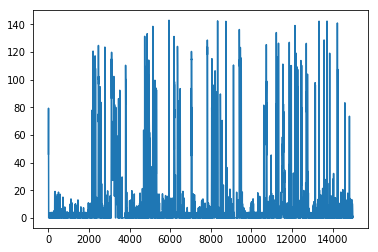

In [20]:
plt.plot(sel_counts[:,3])
plt.show()

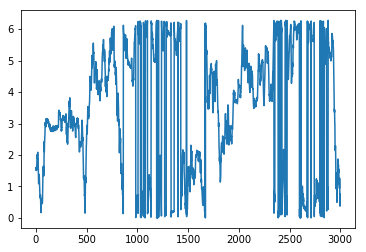

In [21]:
plt.plot(tmp_angles[3000:6000])
plt.show()

In [170]:
%matplotlib notebook

In [14]:
%matplotlib inline

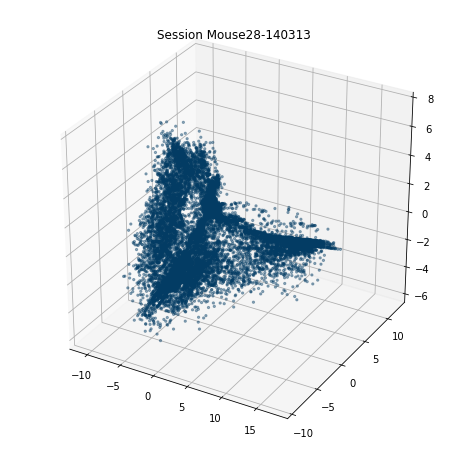

In [22]:
# plotting
if to_plot:
    fig = plt.figure(figsize=(8,8))
    if target_dim == 1:
        ax = fig.add_subplot(111)
        ax.scatter(range(0,desired_nSamples), to_save[state], s=10, alpha=0.4, 
            color=cols[state])
        if condition == 'joint':
            ax.scatter(to_save[state2][:,0], to_save[state2][:,1], s=10, alpha=0.4, 
                color=cols[state2])
    if target_dim == 2:
        ax = fig.add_subplot(111)
        ax.scatter(to_save[state][:,0], to_save[state][:,1], s=10, alpha=0.4, 
            color=cols[state])
        if condition == 'joint':
            ax.scatter(to_save[state2][:,0], to_save[state2][:,1], s=10, alpha=0.4, 
                color=cols[state2])
    if target_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(to_save[state][:,0], to_save[state][:,1], to_save[state][:,2], 
            s=5, alpha=0.4, edgecolor='face', c=cols[state])
        if condition == 'joint':
            ax.scatter(to_save[state2][:,0], to_save[state2][:,1], to_save[state2][:,2], 
                s=5, alpha=0.4, edgecolor='face', c=cols[state2])
    ax.set_title('Session %s'%(session))
    plt.show()

The data from a single session in which 22 neurons recorded from thalamus above is reduced using a nonlinear dim-red method to visualize in 3-d space.

In [ ]:
plt.scatter(tmp_angles[0:15000], to_save[state], s=10, alpha=0.4, 
            color=cols[state])
plt.show()

In [23]:
counts.shape

(22864, 22)

## Finding the right manifold in high dimensional space

I will visualize the manifold above for a random window of time. Then, I will add random nosiy neurons to the recording set to increase the dimensionality of the data. More importantly to introduce irrelevant dimensions to the dataset. Then, I will use the nonlinear mapping again to see how these irrelevant dimensions changes the mapping and ability to discover a manifold on low dimensional space.

In [24]:
# Non-linear Dimensionality Reduction 
target_dim = 3
iso = manifold.Isomap(n_neighbors=5, n_components=target_dim)
#iso = manifold.MDS(n_components=3)
counts_dimred = iso.fit_transform(counts[3000:6000]) #2000:5000

In [25]:
counts_dimred.shape[0]

3000

In [26]:
def plot_manifold(counts_dimred):
    # plot 3-d scatter
    clr = range(0,counts_dimred.shape[0])
    if to_plot:
        fig = plt.figure(figsize=(8,8))
        if target_dim == 1:
            ax = fig.add_subplot(111)
            ax.scatter(range(0,counts_dimred.shape[0]), counts_dimred, s=10, alpha=0.4, 
                color=clr)
            if condition == 'joint':
                ax.scatter(counts_dimred[:,0], counts_dimred[:,1], s=10, alpha=0.4, 
                    color=cols[state2])
        if target_dim == 2:
            ax = fig.add_subplot(111)
            ax.scatter(counts_dimred[:,0], counts_dimred[:,1], s=10, alpha=0.4, 
                color=clr)
            if condition == 'joint':
                ax.scatter(counts_dimred[:,0], counts_dimred[:,1], s=10, alpha=0.4, 
                    color=cols[state2])
        if target_dim == 3:
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(counts_dimred[:,0], counts_dimred[:,1], counts_dimred[:,2], 
                s=5, alpha=0.4, edgecolor='face', c=cols[state])
            if condition == 'joint':
                ax.scatter(counts_dimred[:,0], counts_dimred[:,1], counts_dimred[:,2], 
                    s=5, alpha=0.4, edgecolor='face', c=cols[state2])
        ax.set_title('Session %s'%(session))
        plt.show()  

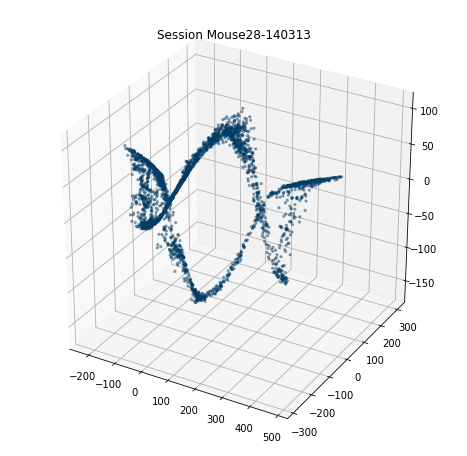

In [27]:
plot_manifold(counts_dimred)

In [28]:
# Add more neurons by generating new neuron through shuffling original neurons. 
# This will allow me to keep similar statistics for each additional neuron but will get rid of any correlations.
import copy
counts2 = copy.deepcopy(counts)

In [29]:
counts2[0]

array([8.71182268e+000, 2.02239637e-020, 6.41130264e-095, 4.61660989e+001,
       8.50437023e-094, 0.00000000e+000, 3.22223542e-116, 8.83320822e-001,
       0.00000000e+000, 5.56697738e-002, 3.10447061e-002, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.78553435e+001, 0.00000000e+000,
       2.04653235e-144, 0.00000000e+000, 3.61945194e+000, 0.00000000e+000,
       1.13719091e-190, 4.84479101e+000])

In [31]:
np.random.shuffle(counts2)
counts2[0]

array([3.87267786e-28, 3.91003536e+00, 3.94818347e+01, 1.25082190e-11,
       3.94802865e+00, 2.69756744e-07, 2.23224176e-02, 1.53046490e+01,
       1.00950749e-01, 2.10330404e-08, 1.14143293e+00, 0.00000000e+00,
       0.00000000e+00, 4.18995816e-17, 1.27547306e+00, 1.39481133e-77,
       2.59994962e+00, 5.87047420e-03, 1.22755239e+01, 3.31784559e-06,
       0.00000000e+00, 6.85131927e+00])

In [32]:
counts2.shape

(22864, 22)

In [33]:
counts12 = np.concatenate((counts, counts2), axis=1)
counts12.shape

(22864, 44)

In [40]:
# Non-linear Dimensionality Reduction 
target_dim = 3
iso = manifold.Isomap(n_neighbors=5, n_components=target_dim)
#iso = manifold.MDS(n_components=3)
counts_dimred = iso.fit_transform(counts12[3000:6000,0:-1]) #2000:5000

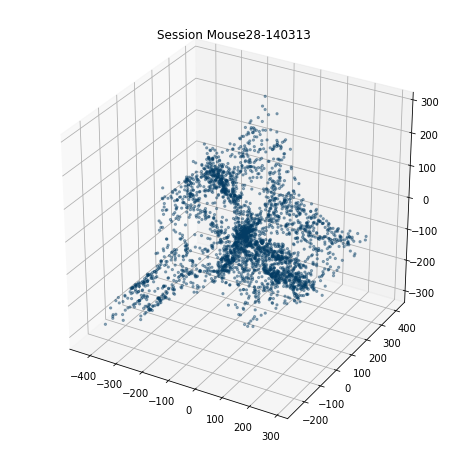

In [41]:
# plotting --- 22 + 22 #22 shuffled neurons added.
plot_manifold(counts_dimred) 

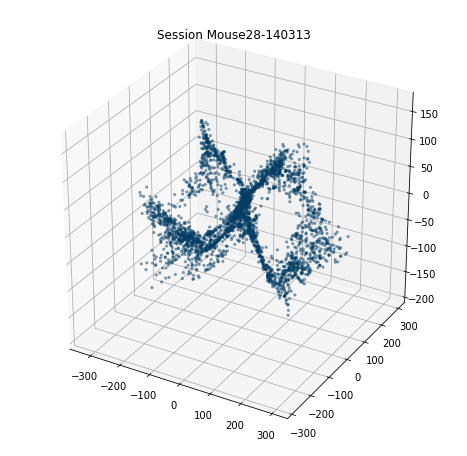

In [37]:
# plotting --- 22+5 #5 shuffled neurons added
plot_manifold(counts_dimred)

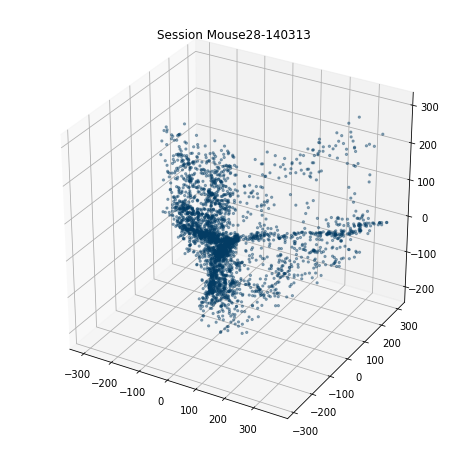

In [39]:
# plotting --- 22+10 #10 shuffled neurons added
plot_manifold(counts_dimred)

### Animation - to do

Traceback (most recent call last):
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/animation.py", line 1775, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


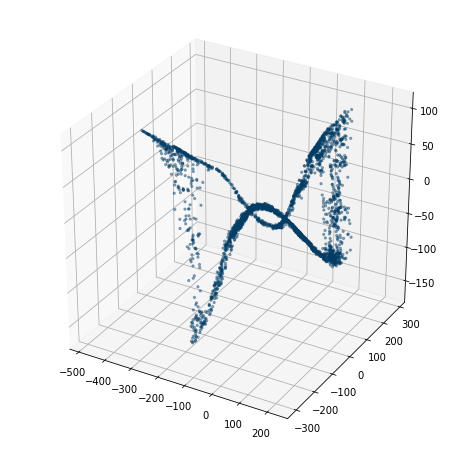

In [112]:
import matplotlib.animation as animation
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


if target_dim == 3:
    ax.scatter(counts_dimred[:,0], counts_dimred[:,1], counts_dimred[:,2], 
        s=5, alpha=0.4, edgecolor='face', c=cols[state])
    
scat = ax.scatter(counts_dimred[0,0], counts_dimred[0,1], counts_dimred[0,2], 
        s=10, alpha=0.4, edgecolor='face', c='red')

def animate(i):   
    ax.scatter(counts_dimred[i,0], counts_dimred[i,1], counts_dimred[i,2], 
        s=10, alpha=0.4, edgecolor='face', c='red')
    
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=1, blit=True)

plt.show()

In [ ]:
anim.save('coil.gif',writer='imagemagick')